# Machine Learning Model - Maternal Health Risk Prediction
## Predicting Future Health Indicators and Risk Levels

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import joblib
import os

%matplotlib inline

In [2]:
# Load engineered features
df = pd.read_csv('../data/processed/maternal_health_with_features.csv')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (24, 30)


,Year,Adolescent birth rate (per 1000 women),Antenatal care coverage - at least four visits (%),Births attended by skilled health personnel (%),Births by caesarean section (%),Number of women of reproductive age (aged 15-49 years) with anaemia (thousands),Prevalence of anaemia in women of reproductive age (aged 15-49) (%),Proportion of births delivered in a health facility (Facility births) (%),Period,Years_Since_2000,...,Adolescent_birth_rate_per_1000_women_YoY_Change,Prevalence_of_anaemia_in_women_of_reproductive_age_aged_15-49_pct_YoY_Change,Skilled_Birth_MA3,Anaemia_MA3,Births_attended_by_skilled_health_personnel_pct_Lag1,Births_attended_by_skilled_health_personnel_pct_Lag2,Prevalence_of_anaemia_in_women_of_reproductive_age_aged_15-49_pct_Lag1,Prevalence_of_anaemia_in_women_of_reproductive_age_aged_15-49_pct_Lag2,Healthcare_Access_Index,Maternal_Risk_Index
0,2000,36.46772,77.3,27.000000,12.4,27.166667,33.033333,19.800000,2000-2009,0,...,NaN,NaN,27.000000,33.033333,NaN,NaN,NaN,NaN,23.400000,73.538852
1,2001,36.46772,77.3,36.666667,12.4,27.466667,32.633333,31.900000,2000-2009,1,...,0.0,-1.210898,31.833333,32.833333,27.000000,NaN,33.033333,NaN,34.283333,66.642300
2,2002,36.46772,77.3,46.333333,12.4,27.933333,32.233333,44.000000,2000-2009,2,...,0.0,-1.225741,36.666667,32.633333,36.666667,27.000000,32.633333,33.033333,45.166667,59.745749
3,2003,36.46772,77.3,56.000000,12.4,28.466667,31.933333,56.100000,2000-2009,3,...,0.0,-0.930714,46.333333,32.266667,46.333333,36.666667,32.233333,32.633333,56.050000,54.573335
4,2004,36.46772,77.3,54.000000,12.4,29.200000,31.700000,57.085714,2000-2009,4,...,0.0,-0.730689,52.111111,31.955556,56.000000,46.333333,31.933333,32.233333,55.542857,50.550346


## Model 1: Risk Level Classification

In [3]:
# Prepare data for classification
# Drop rows with missing Risk_Level
df_class = df.dropna(subset=['Risk_Level']).copy()

# Select features for classification
feature_cols = [
    'Years_Since_2000',
    'Births attended by skilled health personnel (%)',
    'Antenatal care coverage - at least four visits (%)',
    'Adolescent birth rate (per 1000 women)',
    'Prevalence of anaemia in women of reproductive age (aged 15-49) (%)',
    'Healthcare_Access_Index',
    'Maternal_Risk_Index',
    'Skilled_Birth_MA3',
    'Anaemia_MA3'
]

# Remove any rows with NaN in feature columns
df_class = df_class.dropna(subset=feature_cols)

X = df_class[feature_cols]
y = df_class['Risk_Level']

print(f"Features shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")

Features shape: (24, 9)
Target distribution:
Risk_Level
Low Risk       11
High Risk       7
Medium Risk     6
Name: count, dtype: int64


In [4]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (19, 9)
Test set: (5, 9)


In [5]:
# Train Random Forest Classifier
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)

rf_classifier.fit(X_train, y_train)

# Predictions
y_pred = rf_classifier.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

   High Risk       1.00      1.00      1.00         2
    Low Risk       1.00      1.00      1.00         2
 Medium Risk       1.00      1.00      1.00         1

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



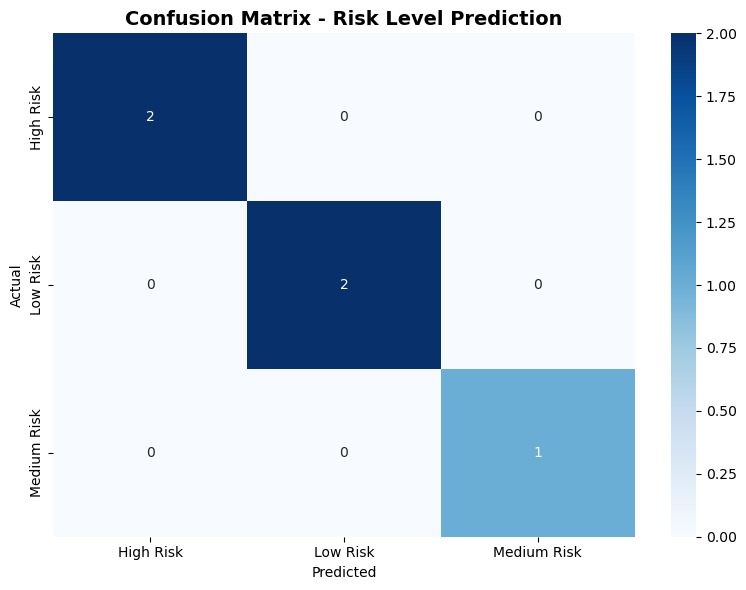

In [6]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=rf_classifier.classes_,
            yticklabels=rf_classifier.classes_)
plt.title('Confusion Matrix - Risk Level Prediction', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

C:\Users\pnali\AppData\Local\Temp\ipykernel_32776\3323669976.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x='Importance', y='Feature', palette='viridis')


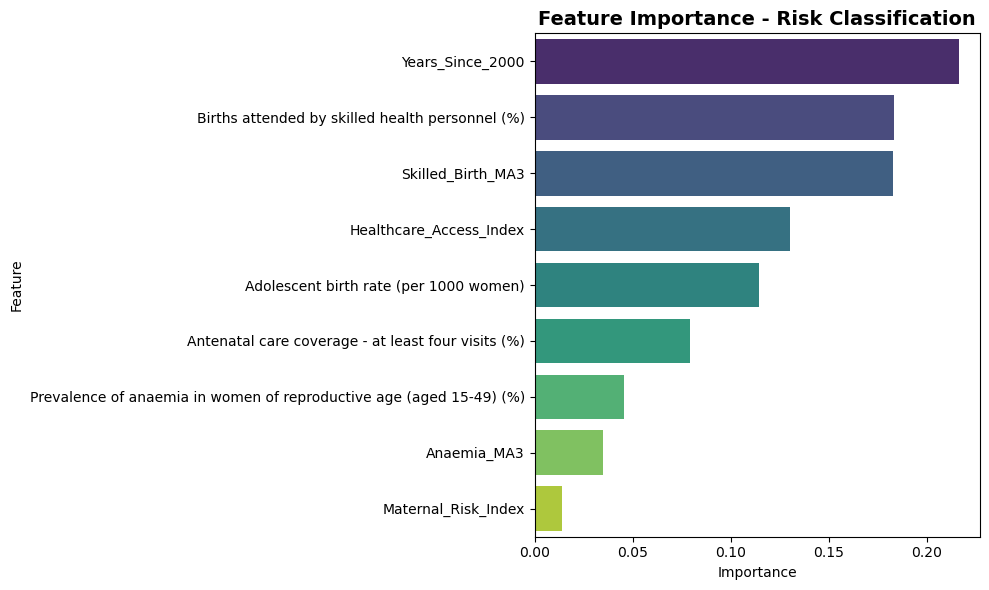


Feature Importance:
                                             Feature  Importance
0                                   Years_Since_2000    0.216150
1    Births attended by skilled health personnel (%)    0.183319
7                                  Skilled_Birth_MA3    0.182479
5                            Healthcare_Access_Index    0.130025
3             Adolescent birth rate (per 1000 women)    0.114306
2  Antenatal care coverage - at least four visits...    0.079207
4  Prevalence of anaemia in women of reproductive...    0.045749
8                                        Anaemia_MA3    0.034711
6                                Maternal_Risk_Index    0.014054


In [7]:
# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_classifier.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance - Risk Classification', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nFeature Importance:")
print(feature_importance)

## Model 2: Skilled Birth Attendance Prediction (Regression)

In [8]:
# Prepare data for regression
df_reg = df.dropna(subset=['Births attended by skilled health personnel (%)']).copy()

regression_features = [
    'Years_Since_2000',
    'Antenatal care coverage - at least four visits (%)',
    'Adolescent birth rate (per 1000 women)',
    'Prevalence of anaemia in women of reproductive age (aged 15-49) (%)',
    'Healthcare_Access_Index'
]

df_reg = df_reg.dropna(subset=regression_features)

X_reg = df_reg[regression_features]
y_reg = df_reg['Births attended by skilled health personnel (%)']

print(f"Regression dataset shape: {X_reg.shape}")

Regression dataset shape: (24, 5)


In [9]:
# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# Train Random Forest Regressor
rf_regressor = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

rf_regressor.fit(X_train_reg, y_train_reg)

# Predictions
y_pred_reg = rf_regressor.predict(X_test_reg)

# Evaluation
mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_reg, y_pred_reg)

print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

Root Mean Squared Error: 6.63
R² Score: 0.9242


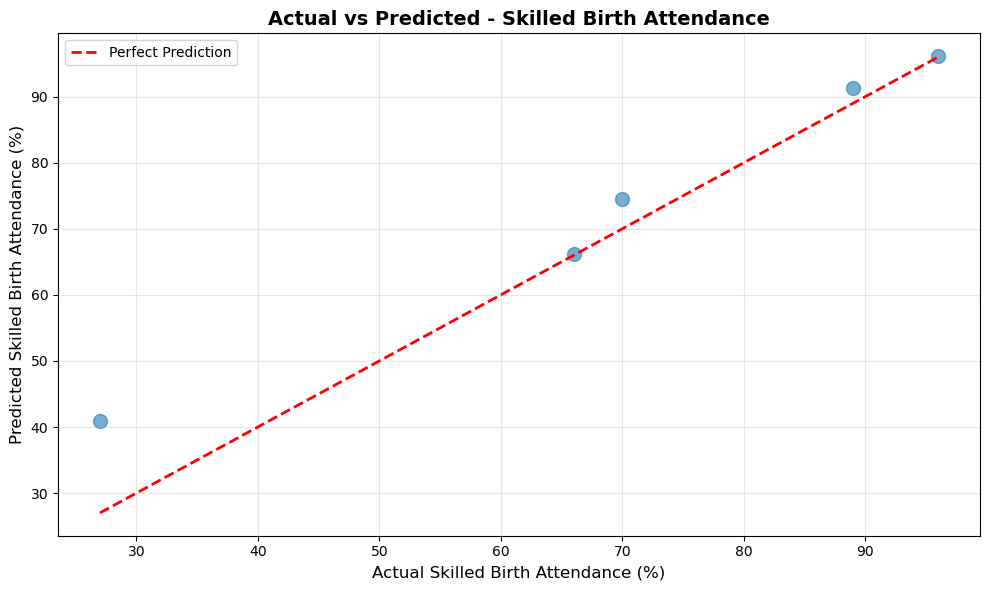

In [10]:
# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.6, s=100)
plt.plot([y_test_reg.min(), y_test_reg.max()], 
         [y_test_reg.min(), y_test_reg.max()], 
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Skilled Birth Attendance (%)', fontsize=12)
plt.ylabel('Predicted Skilled Birth Attendance (%)', fontsize=12)
plt.title('Actual vs Predicted - Skilled Birth Attendance', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Save Models

In [11]:
# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save models
joblib.dump(rf_classifier, '../models/risk_classifier.pkl')
joblib.dump(rf_regressor, '../models/skilled_birth_regressor.pkl')

# Save feature names for later use
joblib.dump(feature_cols, '../models/classification_features.pkl')
joblib.dump(regression_features, '../models/regression_features.pkl')

print("✅ Models saved successfully!")
print("  - models/risk_classifier.pkl")
print("  - models/skilled_birth_regressor.pkl")
print("  - models/classification_features.pkl")
print("  - models/regression_features.pkl")

✅ Models saved successfully!
  - models/risk_classifier.pkl
  - models/skilled_birth_regressor.pkl
  - models/classification_features.pkl
  - models/regression_features.pkl


## Test Model Loading

In [12]:
# Test loading models
loaded_classifier = joblib.load('../models/risk_classifier.pkl')
loaded_regressor = joblib.load('../models/skilled_birth_regressor.pkl')

print("✅ Models loaded successfully!")
print(f"Classifier type: {type(loaded_classifier)}")
print(f"Regressor type: {type(loaded_regressor)}")

✅ Models loaded successfully!
Classifier type: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Regressor type: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
